In [1]:
import pandas as pd
import numpy as np
import scipy.stats as ss
from sklearn import preprocessing
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import Formatter as FM
from GeneralUtilities import GeneralUtilities
GU = GeneralUtilities()



In [2]:
dataPath = 'C:\\Users\\Wilson\\Desktop\\'
fileInName = 'sample2'
fileOutName = 'sample2_'

df_in = pd.read_csv(dataPath + fileInName + '.csv')
df = FM.FM(df_in, ['ticker','field','value'])
GU.outputFile(dataPath + fileOutName + '.csv', df)    


In [3]:
def isnumber(x):
    try:
        float(x)
        return True
    except:
        return False

#df = pd.read_csv('C:\\Users\\Wilson\\Desktop\\sample2_.csv')
df = df.dropna()

df_m = df[df.applymap(isnumber)].dropna(how='all', axis=1)
df_m = df_m.applymap(float)
measurable_var = df_m.columns

categorical_var = [c for c in df.columns if c not in measurable_var]
df_c = df[categorical_var]

df = pd.concat([df_m, df_c], axis=1)

print(df.head())

                    DUR_ADJ_MID  YAS_MOD_DUR    CPN  MTY_YEARS_TDY  \
ticker                                                               
CA06415EXV24 Corp@     4.292277     4.293025  2.490       4.613279   
XS1372846003 Corp@     5.229251     5.231372  4.250       6.039699   
XS1551677260 Corp@     6.372841     6.375595  2.750       6.970568   
SG6W16984513 Corp@     2.370407     2.370915  3.650       7.526352   
XS1932866079 Corp@     7.289484     7.293304  5.125       8.980151   

                   COUNTRY_FULL_NAME INDUSTRY_SECTOR CNTRY_OF_DOMICILE  \
ticker                                                                   
CA06415EXV24 Corp@            CANADA       Financial                CA   
XS1372846003 Corp@             INDIA       Utilities                IN   
XS1551677260 Corp@             INDIA       Utilities                IN   
SG6W16984513 Corp@         SINGAPORE       Financial                SG   
XS1932866079 Corp@             INDIA          Energy             

In [4]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [5]:
def correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator/denominator)
    return eta

In [7]:
cor = pd.DataFrame()
for i, cm1 in enumerate(df.columns):
    for j, cm2 in enumerate(df.columns):
        if cm1 in categorical_var and cm2 in categorical_var:
            r = cramers_v(df[cm1], df[cm2])
            cor.loc[cm1, cm2] = r
        elif cm1 in measurable_var and cm2 in measurable_var:
            r, _ = ss.pearsonr(df[cm1], df[cm2])
            cor.loc[cm1, cm2] = abs(r)
        elif cm1 in categorical_var and cm2 in measurable_var:
            r = correlation_ratio(df[cm1], df[cm2])
            cor.loc[cm1, cm2] = r
        else:
            r = correlation_ratio(df[cm2], df[cm1])
            cor.loc[cm1, cm2] = r
cor

DUR_ADJ_MID  YAS_MOD_DUR       CPN  MTY_YEARS_TDY  \
DUR_ADJ_MID           1.000000     0.999747  0.016464       0.693337   
YAS_MOD_DUR           0.999747     1.000000  0.018801       0.693550   
CPN                   0.016464     0.018801  1.000000       0.056989   
MTY_YEARS_TDY         0.693337     0.693550  0.056989       1.000000   
COUNTRY_FULL_NAME     0.294448     0.294292  0.453188       0.286014   
INDUSTRY_SECTOR       0.208131     0.208671  0.205197       0.192833   
CNTRY_OF_DOMICILE     0.308813     0.309385  0.517483       0.297585   
CURRENCY              0.145723     0.145574  0.331202       0.132327   

                   COUNTRY_FULL_NAME  INDUSTRY_SECTOR  CNTRY_OF_DOMICILE  \
DUR_ADJ_MID                 0.294448         0.208131           0.308813   
YAS_MOD_DUR                 0.294292         0.208671           0.309385   
CPN                         0.453188         0.205197           0.517483   
MTY_YEARS_TDY               0.286014         0.192833           0.297585   
COUNTRY_FULL_NAME           1.000000         0.230738           0.896693   
INDUSTRY_SECTOR             0.230738         1.000000           0.227881   
CNTRY_OF_DOMICILE           0.896693         0.227881           1.000000   
CURRENCY                    0.370389         0.117845           0.395138   

                   CURRENCY  
DUR_ADJ_MID        0.145723  
YAS_MOD_DUR        0.145574  
CPN                0.331202  
MTY_YEARS_TDY      0.132327  
COUNTRY_FULL_NAME  0.370389  
INDUSTRY_SECTOR    0.117845  
CNTRY_OF_DOMICILE  0.395138  
CURRENCY           1.000000

In [8]:
# manual selection
sel = ['DUR_ADJ_MID','CPN','MTY_YEARS_TDY','INDUSTRY_SECTOR','CNTRY_OF_DOMICILE','CURRENCY']
df_sel = df[sel]

In [14]:
dummy_var = ['INDUSTRY_SECTOR','CNTRY_OF_DOMICILE','CURRENCY']

var = []
for dv in dummy_var:
    dummy = pd.get_dummies(df_sel[dv], drop_first=True)
    var.append(dummy)
for v in df_sel.columns:
    if v not in dummy_var:
        var.append(df_sel[v])

df_d = pd.concat(var, axis=1)

print(df_d.head())



                    Communications  Consumer, Cyclical  \
ticker                                                   
CA06415EXV24 Corp@               0                   0   
XS1372846003 Corp@               0                   0   
XS1551677260 Corp@               0                   0   
SG6W16984513 Corp@               0                   0   
XS1932866079 Corp@               0                   0   

                    Consumer, Non-cyclical  Diversified  Energy  Financial  \
ticker                                                                       
CA06415EXV24 Corp@                       0            0       0          1   
XS1372846003 Corp@                       0            0       0          0   
XS1551677260 Corp@                       0            0       0          0   
SG6W16984513 Corp@                       0            0       0          1   
XS1932866079 Corp@                       0            0       1          0   

                    Government  Industrial  Te

In [15]:
min_max_scaler = preprocessing.MinMaxScaler()
df_m = min_max_scaler.fit_transform(df_d)
print(df_m)

df_mt = df_m.T
print(df_mt)

pca = PCA(n_components=20)
pca.fit(df_mt)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)
print(pca.components_)

[[0.         0.         0.         ... 0.22361627 0.12687813 0.08137283]
 [0.         0.         0.         ... 0.27249335 0.27378965 0.10659309]
 [0.         0.         0.         ... 0.33214858 0.14858097 0.1230516 ]
 ...
 [0.         0.         0.         ... 0.04168426 0.28422371 0.0144254 ]
 [0.         0.         0.         ... 0.11337435 0.16944908 0.03998451]
 [0.         0.         0.         ... 0.09073951 0.14858097 0.03170684]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.22361627 0.27249335 0.33214858 ... 0.04168426 0.11337435 0.09073951]
 [0.12687813 0.27378965 0.14858097 ... 0.28422371 0.16944908 0.14858097]
 [0.08137283 0.10659309 0.1230516  ... 0.0144254  0.03998451 0.03170684]]
[0.36976819 0.104392   0.05547447 0.04828178 0.035163   0.02919734
 0.02817751 0.02533692 0.02318571 0.02200758 

<Container object of 1148 artists>

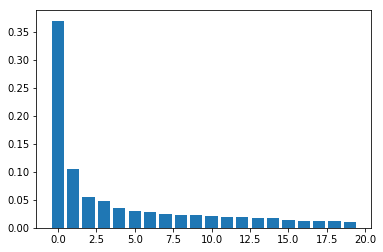

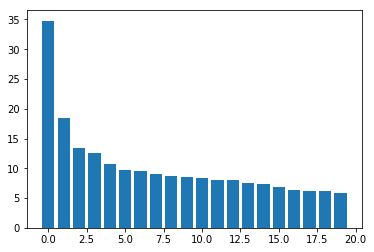

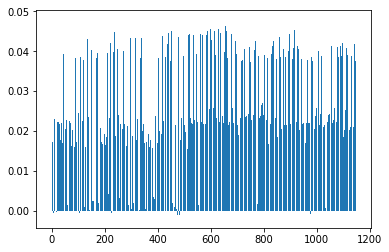

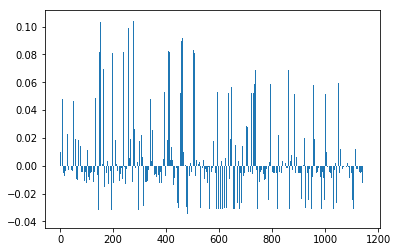

In [16]:
plt.figure()
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)

plt.figure()
plt.bar(range(len(pca.singular_values_)), pca.singular_values_)

plt.figure()
plt.bar(range(len(pca.components_[0])), pca.components_[0])

plt.figure()
plt.bar(range(len(pca.components_[1])), pca.components_[1])

plt.figure()
plt.bar(range(len(pca.components_[2])), pca.components_[2])

In [17]:
print(pca.components_.shape)

idx0 = abs(pca.components_[0]).argsort()[-200:][::-1]
print(idx0)
print(pca.components_[0][idx0])
print(df.index[idx0])
weight = pca.components_[0][idx0]
weight /= sum(weight)
print(weight)

idx1 = abs(pca.components_[1]).argsort()[-200:][::-1]
print(idx1)
print(pca.components_[1][idx1])
print(df.index[idx1])
weight = pca.components_[1][idx1]
weight /= sum(weight)
print(weight)

idx2 = abs(pca.components_[2]).argsort()[-200:][::-1]
print(idx2)
print(pca.components_[2][idx2])
print(df.index[idx2])
weight = pca.components_[2][idx2]
weight /= sum(weight)
print(weight)



(20, 1148)
[ 533  528  529  986  530  620  615 1107  656  872  617  651  677  670
  917  600  518  821  679  629  628 1077  599  587  898  915  419  590
  446  916  598  447  601  596  653  564  627  445  658  521  659  452
  614  646  513  588  751  948  605  619  570  589  655  926  865  237
  591  517  637  925  451  434  630  442  817  441  864  949  657 1031
  435  632  626  897  678  520  562  744  613  820  561  534  604  672
  516  568  584  743  535  745  444  569  323  563  567  418  315  440
  798  934  477  859  583  621  853  480  478  987  316  654  297  896
  339  135  725  879  660  479  137  296 1126  295  603  194  538  724
  145  721  837  693  769  838  676  729 1105  770   95  758  860 1113
  454  222 1097  594  221  625 1140  649  685  994  437 1142  962  884
  272  394  877 1002 1034  223  635 1089  927  833  593  415 1055  161
  597  147 1092  771  746  235  367  338 1135 1051 1078 1024  940 1139
  700  289  912 1079 1091  244  913 1112 1001  941  240  830 1011 

In [18]:
print(df.iloc[idx0])

                    DUR_ADJ_MID  YAS_MOD_DUR     CPN  MTY_YEARS_TDY  \
ticker                                                                
XS2100655807 Corp@     1.761206     1.762746  12.950       2.083504   
XS1937801212 Corp@     0.925275     0.925582  11.750       1.040383   
XS2002235518 Corp@     1.185369     1.185712  11.500       2.965092   
XS1950819729 Corp@     1.336641     1.337067  11.250       1.524983   
XS2030334192 Corp@     2.826567     2.827469  10.875       3.441478   
...                         ...          ...     ...            ...   
XS1317967146 Corp@     0.746253     0.746434   3.750       0.769336   
XS1810682564 Corp@     1.113443     1.114410   6.500       1.193703   
US172967LC35 Corp@     1.679219     1.679394   2.900       1.820671   
XS1717207960 Corp@     3.213803     3.214450   3.256       3.411362   
XS2001732010 Corp@     2.182069     2.182708   3.375       2.291581   

                   COUNTRY_FULL_NAME INDUSTRY_SECTOR CNTRY_OF_DOMICILE  \
ti

In [19]:
print(df.iloc[idx1])

                    DUR_ADJ_MID  YAS_MOD_DUR   CPN  MTY_YEARS_TDY  \
ticker                                                              
HK0000332574 Corp@     0.075198     0.075270  1.96       0.090349   
HK0000304854 Corp@     1.446263     1.447666  1.80       1.511294   
HK0000498771 Corp@     1.126766     1.127521  2.45       1.177276   
HK0000416336 Corp@     1.156680     1.158141  2.75       1.212868   
HK0000463023 Corp@     0.735172     0.735670  3.30       0.772074   
...                         ...          ...   ...            ...   
US852061AR17 Corp@     0.480688     0.480809  7.00       0.506502   
USU81193AL54 Corp@     2.632252     2.633456  5.25       3.132101   
US852061AS99 Corp@     2.513872     2.514652  6.00       2.757016   
US228189AB23 Corp@     2.731141     2.731752  4.50       2.924025   
US25470XAL91 Corp@     2.796025     2.797050  5.00       3.085558   

                   COUNTRY_FULL_NAME INDUSTRY_SECTOR CNTRY_OF_DOMICILE  \
ticker                      

In [20]:
print(df.iloc[idx2])

                    DUR_ADJ_MID  YAS_MOD_DUR    CPN  MTY_YEARS_TDY  \
ticker                                                               
HK0000201233 Corp@     4.085514     4.087539  1.960       4.306639   
HK0000149721 Corp@     3.056447     3.058512  2.150       3.238877   
HK4169039582 Corp@     2.369227     2.354534  4.650       2.543463   
HK0000123213 Corp@     2.428443     2.429533  2.250       2.562628   
HK0000114840 Corp@     2.294355     2.295713  0.970       2.351814   
...                         ...          ...    ...            ...   
XS1879843438 Corp@     1.539169     1.540546  3.950       1.620808   
XS1920256564 Corp@     0.790674     0.790970  8.750       0.832307   
XS1805359939 Corp@     1.093324     1.093631  6.950       1.177276   
XS1801151371 Corp@     1.115598     1.116249  6.875       1.193703   
XS1811023065 Corp@     1.109600     1.110231  7.000       1.199179   

                   COUNTRY_FULL_NAME INDUSTRY_SECTOR CNTRY_OF_DOMICILE  \
ticker         

In [2]:
(3*10+4)/(10**2)

0.34